In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [3]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        if uniqueEntities[i]["SHARPE"] > 1.0 and uniqueEntities[i]["TREYNOR"] > 0.0\
            and uniqueEntities[i]["ACTIVITY"] > 0.7 and uniqueEntities[i]["ROLLING SHARPE BETA"] < 0.2:
            uniqueModelsToKeep.append(uniqueModels[i])
        else:
            continue
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [4]:
# uniqueModels = getAllUniqueModels()

In [5]:
uniqueModels = getUniqueModelsForTicker("GDX")

***ORIGINAL MODELS***
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 25)
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
***UNIQUE MODELS***
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
25TH PERCENTILE SHARPE -0.06404245701378208
ACTIVITY 0.9383306751727805
ALPHA 0.15737861241292164
ANNUALIZED RETURN 0.1492428364578131
BETA 0.04303163368104683
MIN ROLLING SHARPE -1.3015453614069352
OOS_ACTIVITY 0.9285714285714286
OOS_ALPHA 0.24724207798779022
OOS_ANNUALIZED RETURN 0.21437539076846468
OOS_BETA 0.1462585633448695
OOS_RAW BETA 0.2124495967741927
OOS_RELATIVE SHARPE -2.716910438744654
OOS_SHARPE 1.1373425674727933
OOS_SHARPE DIFFERENCE 1.7997781504868842
OOS_SOLAR 2.5945967905332097
OOS_STABILITY 0.6804902423980826
OOS_TOTAL DAYS SEEN 252
OOS_TREYNOR 3.2997136458828358
RAW BETA 0.13233634885713844
RELATIVE SHARPE 3.30427328816416
ROLLING SHARPE BETA 0.4965587906184446
ROLLING SHARPE ERROR 0.8927249942480756
ROLLING SHARPE STABILITY

In [6]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, algoPredictions = dataAck.getModelData(mod)
        algoReturn.columns = [str(mod.describe())]
        algoPredictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = algoPredictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(algoPredictions)
    return aggregateReturns, aggregatePredictions

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions = generateAllReturnsFromCache(uniqueModels)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [7]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
RSP
GDX
SPY
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
ATTEMPTING PULL bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a


In [8]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)"
2009-02-13,-0.0625
2009-02-17,-0.1250
2009-02-18,-0.1875
2009-02-19,-0.3125
2009-02-20,-0.4375
2009-02-23,-0.5625
2009-02-24,-0.6875
2009-02-25,-0.6875
2009-02-26,-0.6250
2009-02-27,-0.5625


,"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)",Factor Return
"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)",1.000000,0.079897
Factor Return,0.079897,1.000000


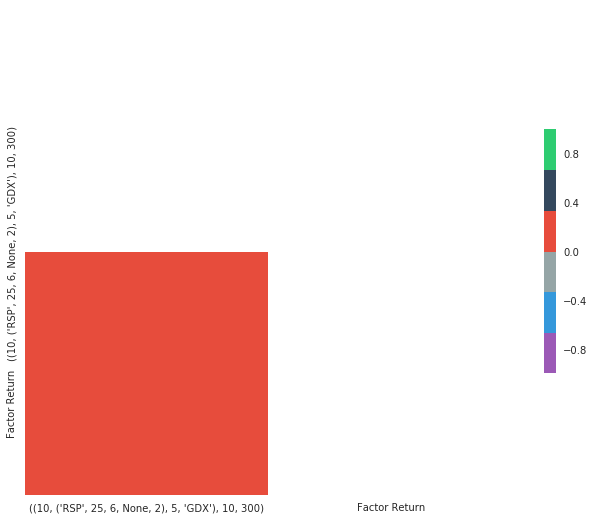

,"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)",Factor Return
"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)",0.000166,0.000011
Factor Return,0.000011,0.000105


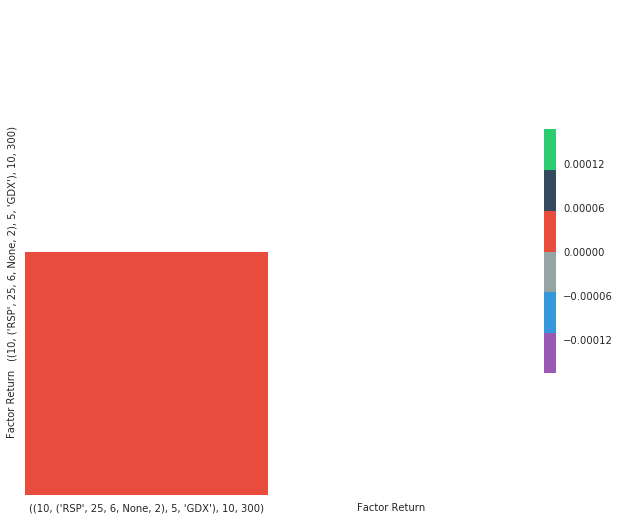

In [9]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [10]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
NEED TO STORE 2133


In [11]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="Simple Test GDX vs SPY", benchmark=factorToTrade)

PORTFOLIO HASH: 539b9993d5b40e18a9ba47216acf9cba127b7bd24483729e18a2c4e2
bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a


In [12]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a']

In [13]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [14]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-02-13,-0.002312
2009-02-17,-0.001250
2009-02-18,0.008680
2009-02-19,-0.012188
2009-02-20,0.006616
2009-02-23,0.045808
2009-02-24,0.012313
2009-02-25,-0.012538
2009-02-26,0.002612
2009-02-27,0.038276


In [15]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-02-13,-0.002312
2009-02-17,-0.001250
2009-02-18,0.008680
2009-02-19,-0.012188
2009-02-20,0.006616
2009-02-23,0.045808
2009-02-24,0.012313
2009-02-25,-0.012538
2009-02-26,0.002612
2009-02-27,0.038276


,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-02-13,-0.0625
2009-02-17,-0.1250
2009-02-18,-0.1875
2009-02-19,-0.3125
2009-02-20,-0.4375
2009-02-23,-0.5625
2009-02-24,-0.6875
2009-02-25,-0.6875
2009-02-26,-0.6250
2009-02-27,-0.5625


In [16]:
if len(allModels) > 1:
    hrpReturns, historicalWeights = portfolioGeneration.\
        produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
        22, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
else:
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: 1.0, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)

In [17]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '539b9993d5b40e18a9ba47216acf9cba127b7bd24483729e18a2c4e2', 'description': 'Simple Test GDX vs SPY', 'benchmark': 'SPY'}
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
